<h2> 🕵🏻 Anomaly Detection: Expedia Hotel 🏨  </h2>

<img src="https://assets.materialup.com/uploads/132da5cf-4213-43fa-961a-b133e0b5f80d/preview.gif" height=98% width=98% style="margin-left:1%">

# Problem Statement: Expedia Hotel 

<img src="https://s27.q4cdn.com/708721433/files/images/new-logos/image-(10).png" height=50% width=50% style="margin-left:25%; display:inline;">

The [**Dataset**](https://www.kaggle.com/competitions/expedia-personalized-sort) is related to tourism sector and is multivariate, dependent on time series. The main objective here is to check and observe the hotel prices from the data set of expedia hotel search. I have implemented different models here to check the prices hikes and lows. 

[**Reference**](https://www.kaggle.com/code/bimimi/time-series-anomaly-detection)

In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns 
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
plt.style.use(['default'])

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

# !pip install pyemma
# from pyemma import msm
# %matplotlib inline

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/expedia-personalized-sort/testOrderBenchmark.zip
/kaggle/input/expedia-personalized-sort/data.zip
/kaggle/input/expedia-personalized-sort/basicPythonBenchmark.zip
/kaggle/input/expedia-personalized-sort/randomBenchmark.zip
/kaggle/input/expedia-hotel/train.csv
/kaggle/input/expedia-hotel/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/expedia-hotel/train.csv')
# ('/kaggle/input/expedia-hotel/train.csv')

In [3]:
train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
train.isnull().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        9412233
visitor_hist_adr_usd           9409918
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                14630
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           2178380
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      9281966
orig_destination_distance

# Data Set : Expedia Hotel

<img src="https://cdn.dribbble.com/users/3195127/screenshots/15901369/dribbble_4x.png" height=98% width=98% style="margin-left:1%">

*“Hotel” refers to hotels, apartments, B&Bs, hostels and other properties appearing on Expedia’s websites.  Room types are not distinguished and the data can be assumed to apply to the least expensive room type. Most of the data are for searches that resulted in a purchase, but a small proportion are for searches not leading to a purchase. So, the main objective is to check the prices of Hotel Rooms.*

Selecting property / visitor location country / srch_room_count with the most Data Points 

In [5]:
# prop_id corresponding to 
train['prop_id'].value_counts()

104517    4733
124342    4707
68420     4580
134154    4550
40279     4535
          ... 
115966       1
130054       1
131174       1
125775       1
102926       1
Name: prop_id, Length: 136886, dtype: int64

In [6]:
train['visitor_location_country_id'].value_counts()

219    5778805
100     990487
55      580072
216     434568
220     350433
        ...   
144         31
198         30
146         30
24          29
8           27
Name: visitor_location_country_id, Length: 218, dtype: int64

In [7]:
# Num of rooms specified in search by customer
train['srch_room_count'].value_counts()

1    9045780
2     734315
3      92372
4      25023
5       8053
8       4950
6       4345
7       2692
Name: srch_room_count, dtype: int64

In [8]:
# Subset df 
df = train.loc[train['prop_id'] == 104517]

df = df.loc[df['visitor_location_country_id'] == 219]

df = df.loc[df['srch_room_count'] == 1]

# srch_saturday = if stay includes Sat night 
# srch_booking_window = num of days between search date and hotel stay start date 
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 2041 to 9917395
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_time                 3049 non-null   object 
 1   price_usd                 3049 non-null   float64
 2   srch_booking_window       3049 non-null   int64  
 3   srch_saturday_night_bool  3049 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 119.1+ KB


In [10]:
df.describe()

,price_usd,srch_booking_window,srch_saturday_night_bool
count,3049.000000,3049.000000,3049.000000
mean,112.939023,37.082650,0.524434
std,113.374049,46.160272,0.499485
min,0.120000,0.000000,0.000000
25%,67.000000,6.000000,0.000000
50%,100.000000,20.000000,1.000000
75%,141.000000,48.000000,1.000000
max,5584.000000,292.000000,1.000000


In [11]:
train.loc[(train['price_usd'] == 5584) & 
         (train['visitor_location_country_id'] == 219)]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
2905344,195154,2013-04-07 20:59:07,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,28.0,0,NaN,0


👉🏻 Possible wrong search, no intention to book

In [12]:
# Removing 5584 
df = df.loc[df['price_usd'] < 5584]
df['price_usd'].describe()

count    3048.000000
mean      111.144055
std        55.055161
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max       536.000000
Name: price_usd, dtype: float64

In [13]:
df['date_time'].min(), df['date_time'].max()

('2012-11-01 02:48:30', '2013-06-30 22:50:21')

In [14]:
df['date_time'].describe()

df['date_time'] = pd.to_datetime(df['date_time'])

df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2041,2013-03-14 11:27:28,206.0,99,1
3152,2013-01-03 20:48:24,186.0,6,0
5166,2013-01-19 16:51:27,61.0,1,0
10135,2013-01-26 11:34:23,72.0,116,0
10560,2013-04-29 09:39:50,246.0,245,0


In [15]:
import matplotlib.pyplot as plt
import plotly.express as px

In [16]:
fig = px.scatter(df, x=df.columns[0], y=df.columns[1], height=500, width=1200, template='plotly_white')
fig.update_layout(
    title="Time series of room price by date of search",
    yaxis_title="USD",
    xaxis_title="Dates",
    )

In [17]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2041,2013-03-14 11:27:28,206.0,99,1
3152,2013-01-03 20:48:24,186.0,6,0
5166,2013-01-19 16:51:27,61.0,1,0
10135,2013-01-26 11:34:23,72.0,116,0
10560,2013-04-29 09:39:50,246.0,245,0


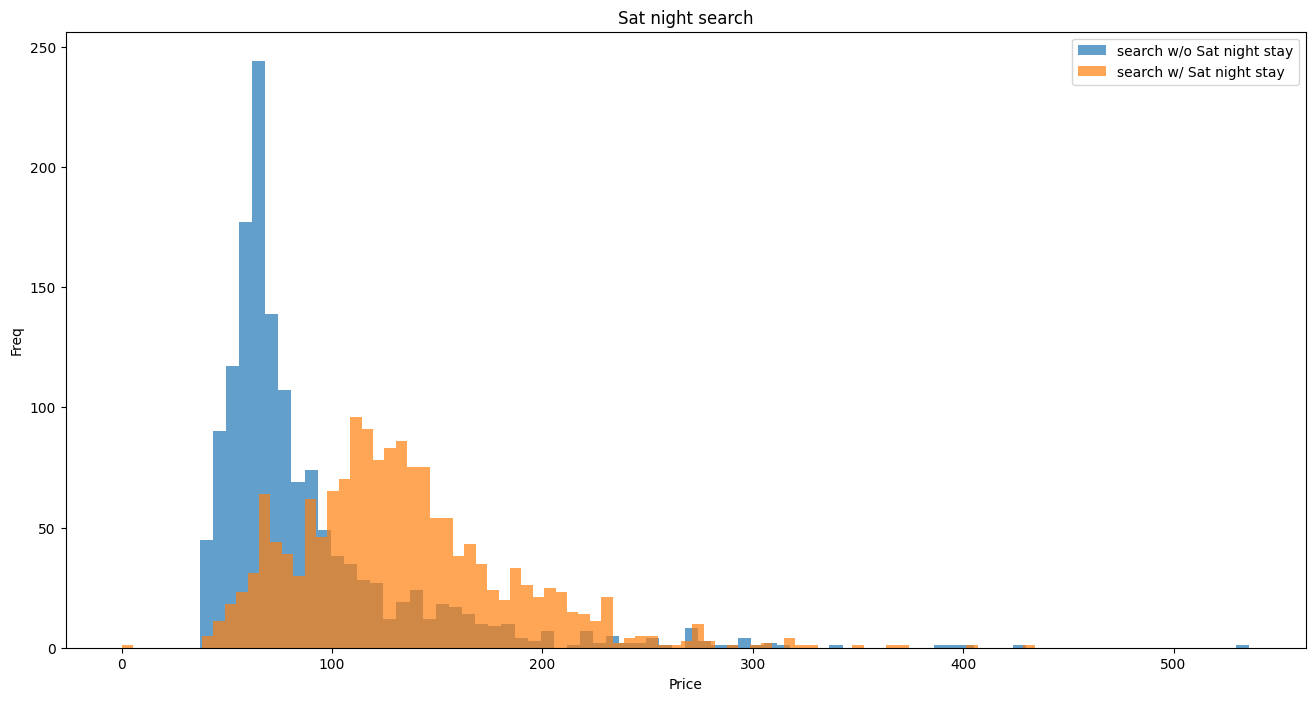

In [18]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

plt.figure(figsize = (16, 8))

plt.hist(a, bins = 80, 
         alpha = 0.7, 
         label = 'search w/o Sat night stay')

plt.hist(b, bins = 80, 
         alpha = 0.7, 
         label = 'search w/ Sat night stay')

plt.xlabel('Price')
plt.ylabel('Freq')
plt.legend()
plt.title('Sat night search')
plt.plot();

In [19]:
df['srch_saturday_night_bool'].value_counts()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64

In [20]:
print('Kurtosis: %f' % df['price_usd'].kurt())
print('Skewness: %f' % df['price_usd'].skew())

Kurtosis: 3.617559
Skewness: 1.443641


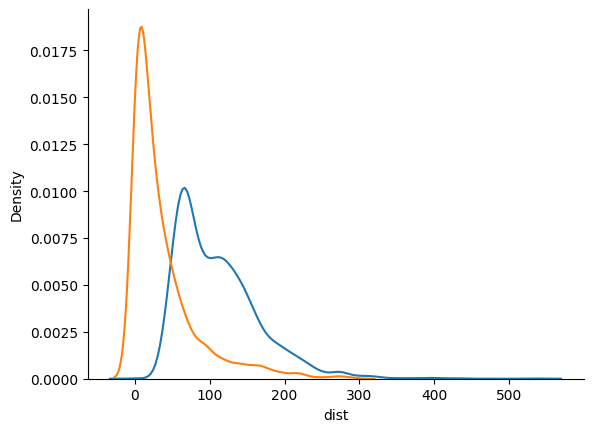

In [21]:
plt.style.use(['default']) 
sns.distplot(df['price_usd'], 
                 hist = False, label = 'USD')

sns.distplot(df['srch_booking_window'], 
                  hist = False, label = 'booking window')

plt.xlabel('dist')
sns.despine()

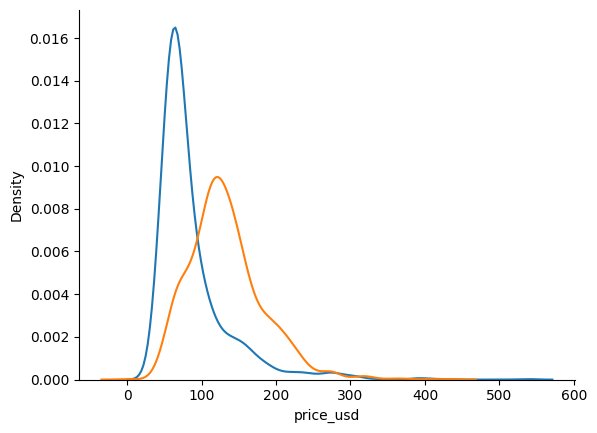

In [22]:
sns.distplot(a, hist = False, rug = False)
sns.distplot(b, hist = False, rug = False)

sns.despine()

In [23]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)

<h2> Cluster-based models </h2>

* K-Means
* Isolation forest
* Clustering

<h3>Potential outliers</h3>

* usd
* srch_booking_window (days between search and first stay date)
* srch_saturday (stay includes sat night

# 1️⃣ K-Means

This method looks at the data points in a dataset and groups those that are similar into a predefined number K of clusters. A threshold value can be added to detect anomalies: if the distance between a data point and its nearest centroid is greater than the threshold value, then it is an anomaly.

<img src="https://www.gatevidyalay.com/wp-content/uploads/2020/01/K-Means-Clustering.png" height=80% width=80% style="margin-left:10%">

In [24]:
# Determine optimal cluster num using elbow method 
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)

kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

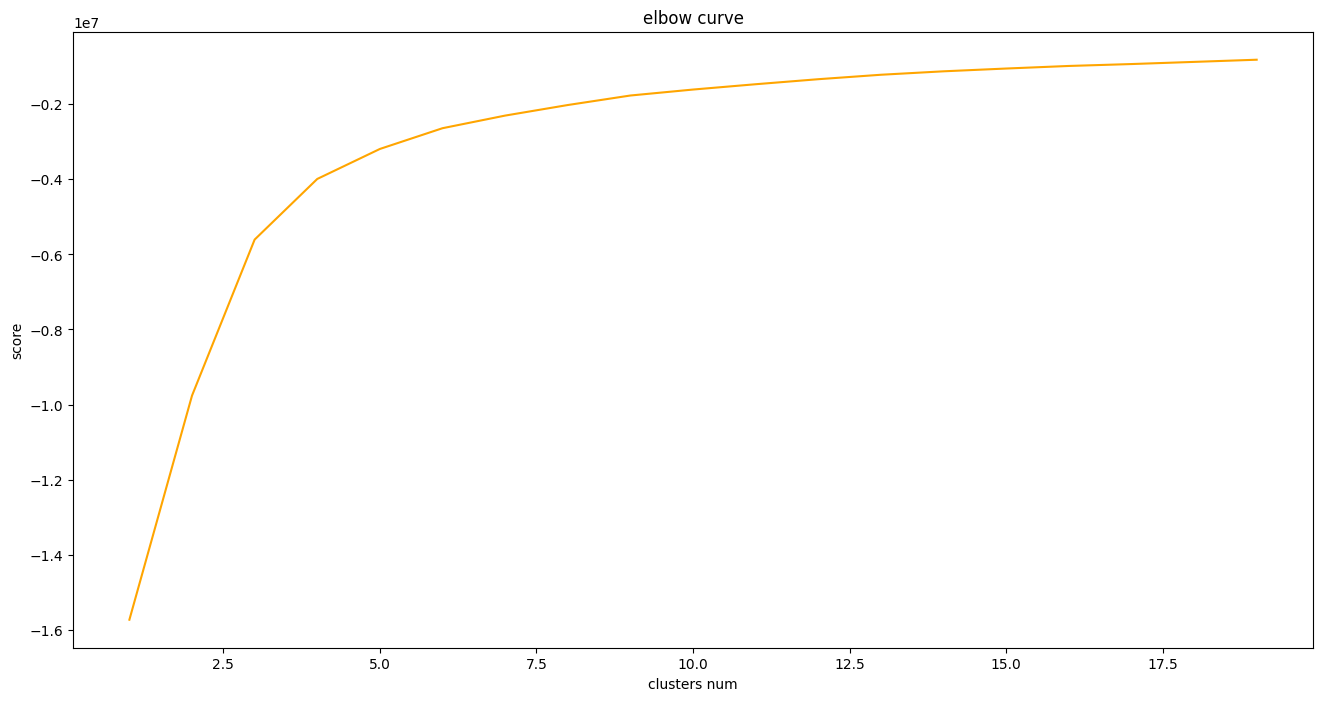

In [25]:
# elbow curve 
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(n_cluster, scores, color = 'orange')

plt.xlabel('clusters num')
plt.ylabel('score')
plt.title('elbow curve')
plt.show();

👉🏻 Setting n_clusters to 7

> n_clusters > 7 = additional clusters do not explain greater variance in variable 
> 
> *where **variable = price_usd**.*

In [26]:
# k means output 
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop = True)

km = KMeans(n_clusters = 7)
km.fit(X)
km.predict(X)

labels = km.labels_

X.head()

,price_usd,srch_booking_window,srch_saturday_night_bool
0,84.0,19,0
1,78.0,16,1
2,114.0,56,1
3,76.0,56,1
4,128.0,0,1


# 2️⃣ 3D clusters 
Plotting using K-Means O/P 

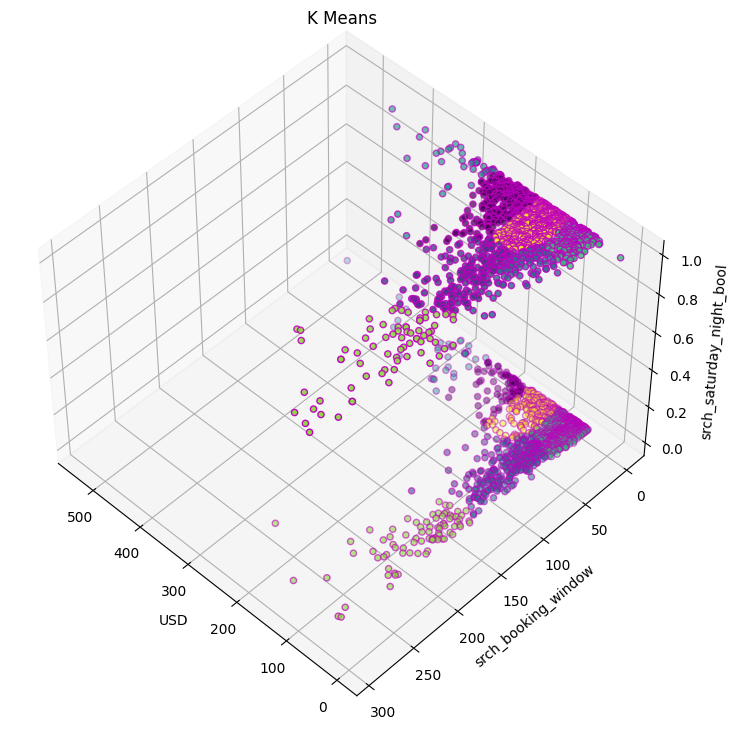

In [27]:
fig = plt.figure(1, figsize = (7, 7))

ax = Axes3D(fig, rect = [0, 0, 0.95, 1], 
            elev = 48, azim = 134)

ax.scatter(X.iloc[:, 0], 
           X.iloc[:, 1], 
           X.iloc[:, 2],
           c = labels.astype(np.float), edgecolor = 'm')

ax.set_xlabel('USD')
ax.set_ylabel('srch_booking_window')
ax.set_zlabel('srch_saturday_night_bool')

plt.title('K Means');

In [28]:
import pylab as pl 

# 3️⃣ PCA 

The PCA-Based Anomaly Detection component solves the problem by analyzing available features to determine what constitutes a "normal" class. The component then applies distance metrics to identify cases that represent anomalies. This approach lets you train a model by using existing imbalanced data.

<img src="https://static-02.hindawi.com/articles/scn/volume-2021/7389943/figures/7389943.fig.005.jpg" height=80% width=80% style="margin-left:10%">

In [29]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

X = data.values
X_std = StandardScaler().fit_transform(X)

# Calc eigenvec cor & eig_vals of covar matrix 
mean_vec = np.mean(X_std, axis = 0)

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# eig_val,eig_vecs tuple
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse = True)

In [30]:
# Calc explained var from eig_vals 
total = sum(eig_vals)

# Individual explained var 
var_exp = [(i/total)*100 for i in sorted(eig_vals, reverse = True)]

# Cumulative explained var 
cum_var_exp = np.cumsum(var_exp)

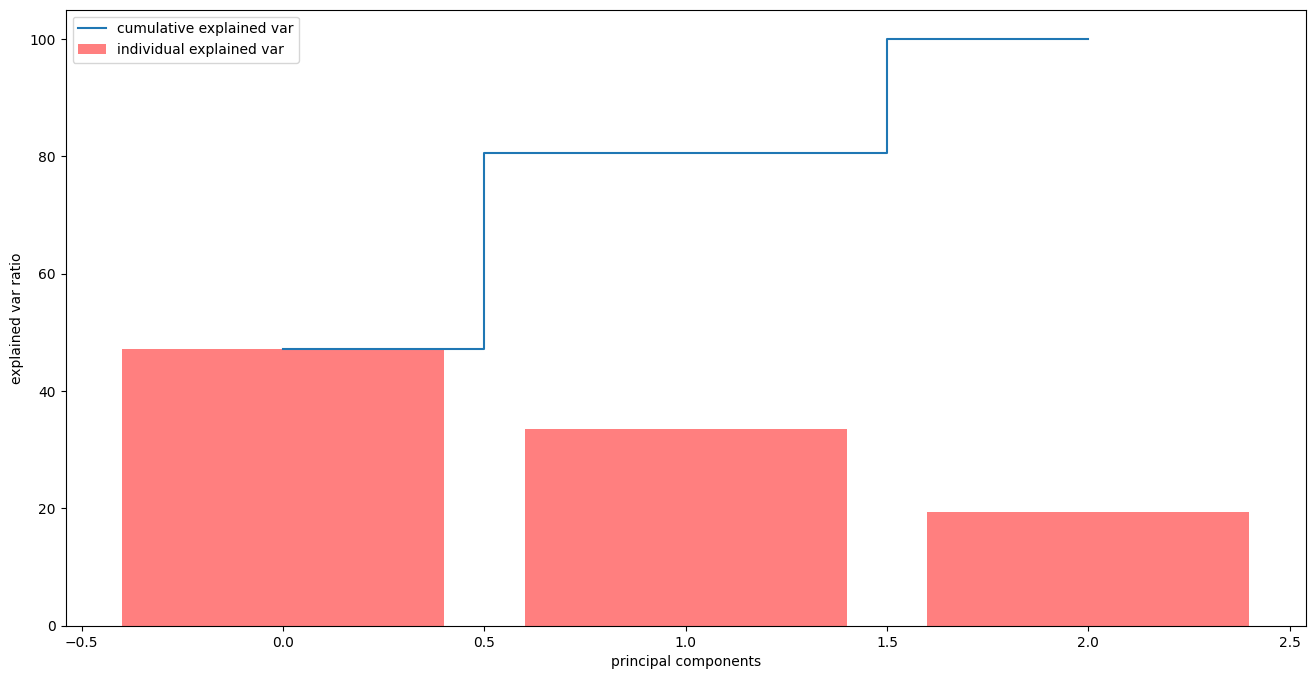

In [31]:
plt.figure(figsize = (16, 8))
plt.bar(range(len(var_exp)), var_exp, 
        alpha = 0.5, align = 'center', 
        label = 'individual explained var', 
        color = 'r'
       )

plt.step(range(len(cum_var_exp)), cum_var_exp,
         where = 'mid',
         label = 'cumulative explained var')

plt.xlabel('principal components')
plt.ylabel('explained var ratio')
plt.legend(loc = 'best')
plt.show();

👉🏻 Component 

> **1** = explains approx 50% of var
> 
> **2** = explains < 40
> 
> **3** = explains < 20 

Components 1 + 2 = explain approx 80% of var 

* set n_components = 2

* standardize features 

In [32]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

# Standardize features
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)

# Reduce components to 2 
pca = PCA(n_components = 2)
data = pca.fit_transform(data)

# Standardize 2 new features 
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [33]:
kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]

df['cluster'] = kmeans[7].predict(data)
df.index = data.index

df['pc1'] = data[0]
df['pc2'] = data[1]
df['cluster'].value_counts()

2    839
1    695
3    459
6    399
5    340
0    151
7     97
4     68
Name: cluster, dtype: int64

In [34]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [35]:
outliers_fraction = 0.01

distance = getDistanceByPoint(data, kmeans[9])
outlier_num = int(outliers_fraction * len(distance))

threshold = distance.nlargest(outlier_num).min()

df['anomaly'] = (distance >= threshold).astype(int)

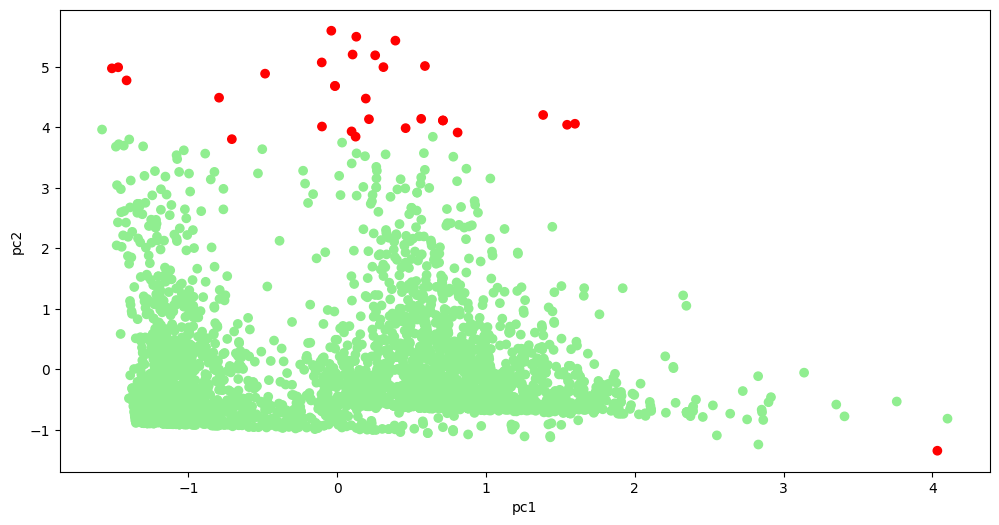

In [36]:
fig, ax = plt.subplots(figsize = (12, 6))

colors = {0:'lightgreen', 1:'red'}

ax.scatter(df['pc1'], df['pc2'], 
           c = df['anomaly'].apply(lambda x: colors[x]))

plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show();

In [37]:
df = df.sort_values('date_time')
df['date_time'] = df.date_time.astype(np.int64)

# object with anomalies
a = df.loc[df['anomaly'] == 1, 
           ['date_time_int', 'price_usd']]

a

,date_time_int,price_usd
8,1351779652000000000,211.0
79,1352307775000000000,126.0
96,1352380267000000000,230.0
102,1352416996000000000,225.0
203,1353254473000000000,116.0
416,1354869170000000000,126.0
858,1357668058000000000,90.0
1005,1358444151000000000,102.0
1140,1359377578000000000,87.0
1157,1359523443000000000,112.0


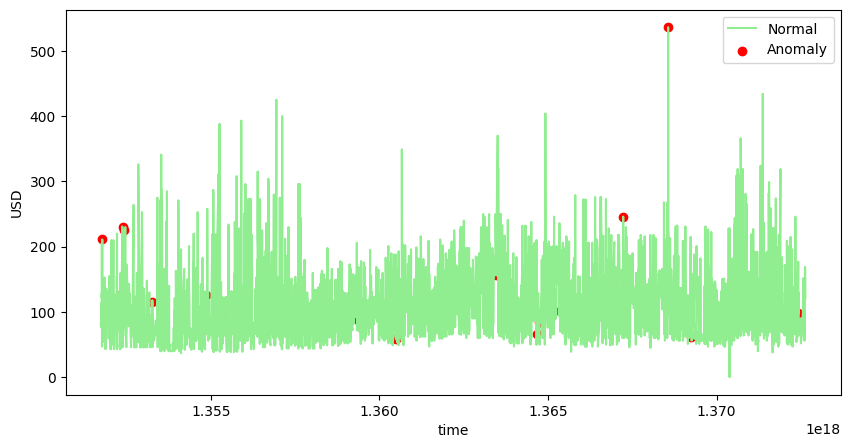

In [38]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'lightgreen', label = 'Normal')

ax.scatter(a['date_time_int'], a['price_usd'],
           color = 'red', label = 'Anomaly')

plt.xlabel('time')
plt.ylabel('USD')
plt.legend()
plt.show();

In [39]:
df['anomaly'].unique()

array([0, 1])

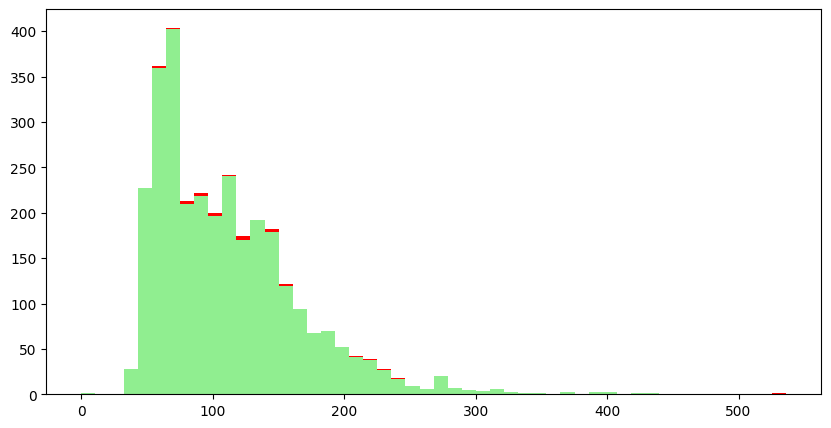

In [40]:
a = df.loc[df['anomaly'] == 0, 'price_usd']
b = df.loc[df['anomaly'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize = (10, 5))
axs.hist([a, b], 
         bins = 50, stacked = True, 
         color = ['lightgreen', 'red'])

plt.show();

In [41]:
df.anomaly.value_counts()

0    3018
1      30
Name: anomaly, dtype: int64

In [42]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,date_time_int,cluster,pc1,pc2,anomaly
0,1351738110000000000,84.0,19,0,1351738110000000000,2,-0.889864,-0.521900,0
1,1351739203000000000,78.0,16,1,1351739203000000000,1,0.230566,-0.272218,0
2,1351760658000000000,114.0,56,1,1351760658000000000,6,0.567439,0.546642,0
3,1351761063000000000,76.0,56,1,1351761063000000000,6,0.155659,0.581776,0
4,1351764925000000000,128.0,0,1,1351764925000000000,1,0.793675,-0.659305,0


# 4️⃣ Isolation Forest

Detect anomalies based on data points that are few and different 

- No use of density / distance measure 
    i.e. different from clustering based / distanced based algorithms 

- Randomly select a feature 
    
- Randomly select a split between max and min values of selected feature 
    
- Length of path, avged over a forest of random trees = measure of normality 

- Random partitioning = shorter path for anomalies

- If forest produces shorter paths for samples, then they are likely to be anomalies 

In Isolation forest on the left.. we can isolate an anomalous point from the rest of the data with just one line, while the normal point on the right requires four lines to isolate completely.

<img src="https://miro.medium.com/max/1400/1*6GFMewU1Aax57nsW2uSakQ.png" height=80% width=80% style="margin-left:10%">

Isolation Forest Algorithm takes advantage of the following properties of anomalous samples - 

> Fewness — anomalous samples are a minority and there will only be a few of them in any dataset.
> 
> Different — anomalous samples have values/attributes that are very different from those of normal samples.
> 

<img src="https://engineering.linkedin.com/content/dam/engineering/site-assets/images/blog/posts/2019/08/IsolationForest1.png" height=70% width=70% style="margin-left:15%">

We can see, Outliers are easier to isolate, while Inliers are harders to isolate..

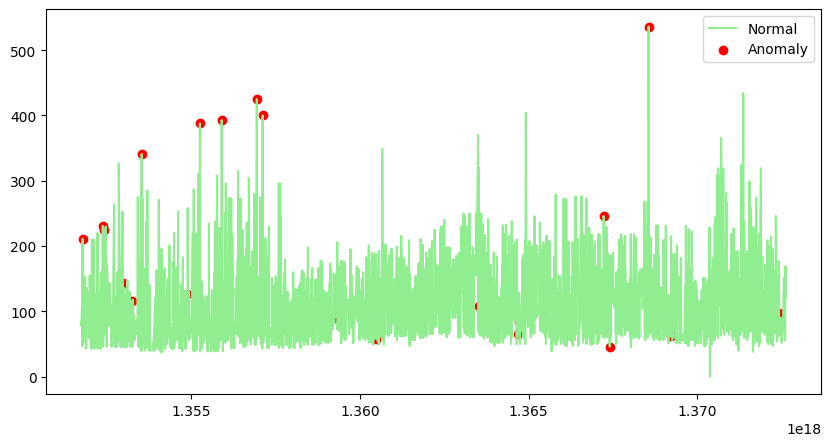

In [43]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

data = pd.DataFrame(np_scaled)

# Isolation forest 
outliers_fraction = 0.01
ifo = IsolationForest(contamination = outliers_fraction)

ifo.fit(data)

df['anomaly1'] = pd.Series(ifo.predict(data))

fig, ax = plt.subplots(figsize = (10, 5))

a = df.loc[df['anomaly1'] == -1, ['date_time_int', 'price_usd']]

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'lightgreen', label = 'Normal')

ax.scatter(a['date_time_int'], a['price_usd'], 
           color = 'red', label = 'Anomaly')

plt.legend()
plt.show();

In [44]:
df['anomaly1'].unique()

array([ 1, -1])

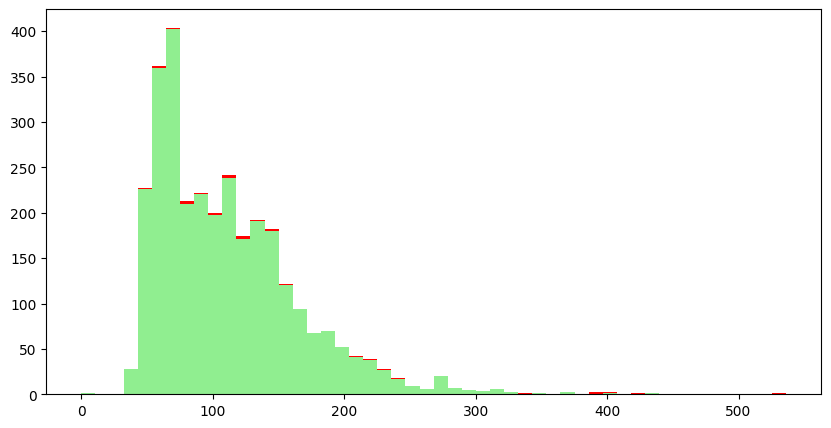

In [45]:
a = df.loc[df['anomaly1'] == 1, 'price_usd']
b = df.loc[df['anomaly1'] == -1, 'price_usd']

fig, ax = plt.subplots(figsize = (10, 5))

ax.hist([a, b],
        bins = 50, stacked = True, 
        color = ['lightgreen', 'red'] )

plt.show();

<h2> Support vector machine models </h2>

Associated with supervised learning 
- One class SVM
- Gaussian distribution 
- Markov chain

<img src="https://documentation.mindsphere.io/MindSphere/apis/analytics-anomalydetection/images/DBSCAN.png" height=70% width=70% style="margin-left:15%">

# 5️⃣ One class SVM 
- Unsupervised Anomaly Detection Method
- Estimate support of high dimensional distribution

In [46]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

data = pd.DataFrame(np_scaled)

# Train 

osvm = OneClassSVM(nu = outliers_fraction, 
                   kernel = 'rbf', 
                   gamma = 0.01)

osvm.fit(data)

df['anomaly2'] = pd.Series(osvm.predict(data))

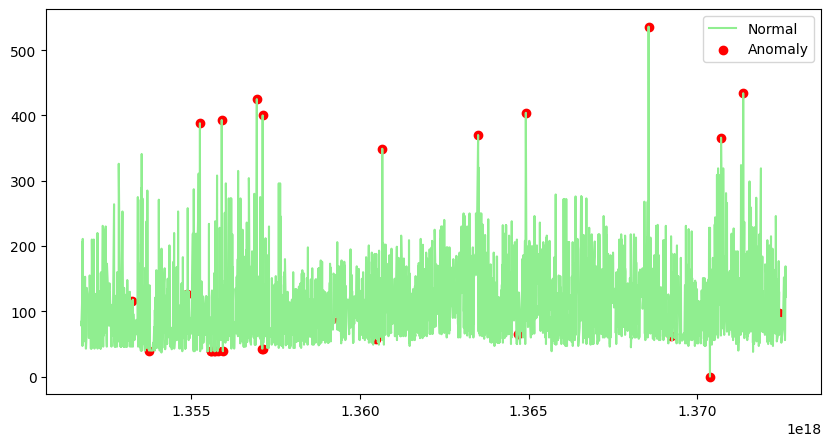

In [47]:
fig, ax = plt.subplots(figsize = (10, 5))

a = df.loc[df['anomaly2'] == -1, 
           ['date_time_int', 'price_usd']]

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'lightgreen', 
        label = 'Normal')

ax.scatter(a['date_time_int'], a['price_usd'], 
           color = 'red', 
           label = 'Anomaly')

plt.legend()
plt.show();

In [48]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,date_time_int,cluster,pc1,pc2,anomaly,anomaly1,anomaly2
0,1351738110000000000,84.0,19,0,1351738110000000000,2,-0.889864,-0.521900,0,1,1
1,1351739203000000000,78.0,16,1,1351739203000000000,1,0.230566,-0.272218,0,1,1
2,1351760658000000000,114.0,56,1,1351760658000000000,6,0.567439,0.546642,0,1,1
3,1351761063000000000,76.0,56,1,1351761063000000000,6,0.155659,0.581776,0,1,1
4,1351764925000000000,128.0,0,1,1351764925000000000,1,0.793675,-0.659305,0,1,1


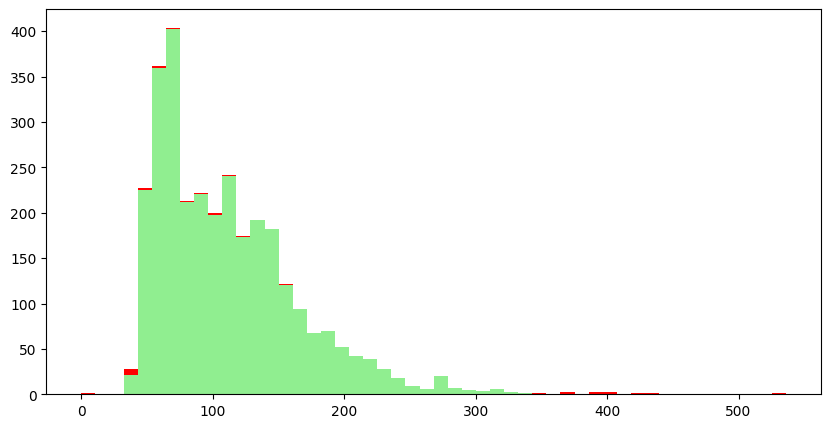

In [49]:
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, ax = plt.subplots(figsize = (10, 5))

ax.hist([a, b], bins = 50, 
        stacked = True, color = ['lightgreen','red'])

plt.show();

In [50]:
df['anomaly2'].value_counts()

 1    3017
-1      31
Name: anomaly2, dtype: int64

# 6️⃣ Gaussian Distribution

<img src="https://miro.medium.com/max/800/1*w5HzgB5ekxQ6Nwmx5ggn8Q.jpeg" height=70% width=70% style="margin-left:15%">

- Assume data is normally distributed

- Use covariance.EllipticEnvelope from scikit-learn to find key params of general distribution by assuming entire dataset = an expression of an underlying multivariate Gaussian distribution

Creating two dfs based on categories defined by sat boolean

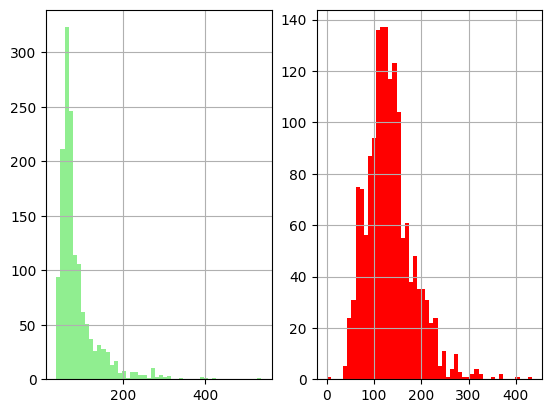

In [51]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

fig, axs = plt.subplots(1, 2)

df_class0.hist(ax = axs[0], bins = 50, color = 'lightgreen')
df_class1.hist(ax = axs[1], bins = 50, color = 'red');

Apply EllipticEnvelope to each category 

Set contamination param (proportion of outliers present in dataset)

Use decision function to compute decision function of given observations (equivalent to shifted Mahalanobis distances. 

Threshold for identifying as outliers = 0 (compatible with other detection algorithms)

predict(x_train) predict labels of X_train according to fitted model

1 = normal
-1 = anomaly

In [52]:
envelope = EllipticEnvelope(contamination = outliers_fraction)

x_train = df_class0.values.reshape(-1, 1)
envelope.fit(x_train)

df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(x_train)
df_class0['anomaly'] = envelope.predict(x_train)

In [53]:
envelope = EllipticEnvelope(contamination = outliers_fraction)

x_train = df_class1.values.reshape(-1, 1)
envelope.fit(x_train)

df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(x_train)
df_class1['anomaly'] = envelope.predict(x_train)

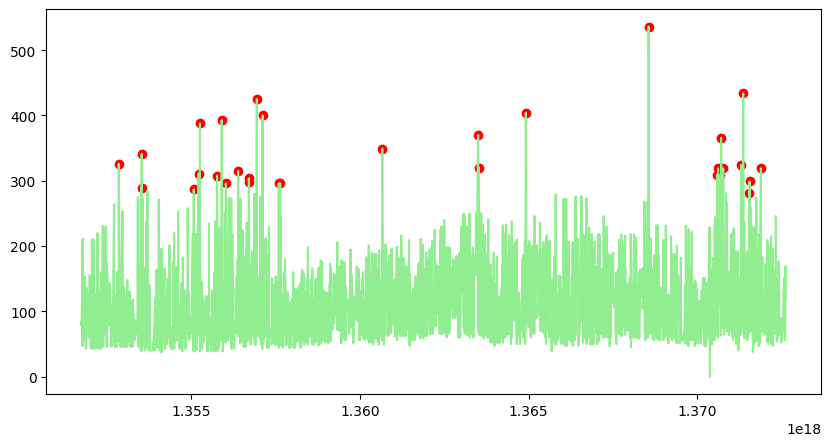

In [54]:
df_class = pd.concat([df_class0, df_class1])
df['anomaly3'] = df_class['anomaly']

fig, ax = plt.subplots(figsize = (10, 5))

a = df.loc[df['anomaly3'] == -1, 
           ('date_time_int', 'price_usd')]

ax.plot(df['date_time_int'], df['price_usd'], 
        color = 'lightgreen')

ax.scatter(a['date_time_int'], a['price_usd'],
          color = 'red')

plt.show();

In [55]:
df['anomaly3'].value_counts()

 1    3017
-1      31
Name: anomaly3, dtype: int64

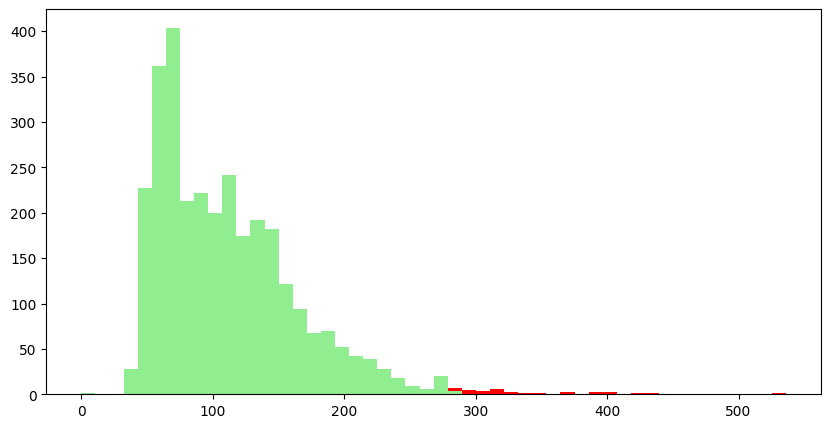

In [56]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, ax = plt.subplots(figsize = (10, 5))
ax.hist([a, b], 
        bins = 50, stacked = True, 
        color = ['lightgreen', 'red'])

plt.show();

# 📝 Analysis &  Conclusion 

👉🏻 Based on this study, we have observed that Algorithms - **K-Means, 3D Cluster, PCA, Isolation Forest, and Gaussian Distribution** have detected the **high prices**.
<!-- 
<img src="https://jonmgomes.com/wp-content/uploads/2020/05/Comp_1.gif" height=60% width=60% style="margin-left:20%"> -->
    
👉🏻 But only **One Class SVM** has detected both high prices as well as **low prices**.
<br><br>
❓ **BUT.. How one class svm made such difference?** 
<br><br>
*SVM is for novelty detection, a max-margin methods, i.e. they do not model a probability distribution... The idea of novelty detection is to detect rare events, i.e. events that happen rarely, and hence, of which you have very little samples.*
    <br><br>
<!-- <br><br> -->


<img src="https://cdn.dribbble.com/users/2828066/screenshots/14755895/media/eac02ec5ba9d0118c3d289d52dbb20ff.gif" height=98% width=98% style="margin-left:1%">